In [1]:
# switch to the project directory
%cd ..
# working directory should be ../FSE

c:\Users\admin\Desktop\research\FSE


In [2]:
from pdi.data.preparation import FeatureSetPreparation, MeanImputation, DeletePreparation, RegressionImputation
from pdi.models.models import AttentionModel
from pdi.models.utils import NeuralNet

EXPERIMENTS = {
    "FSE":{
        "data_prep": FeatureSetPreparation
    },
    "Mean": {
        "data_prep": MeanImputation
    },
    # "Delete": {
    #     "data_prep": DeletePreparation
    # },
    "Regression": {
        "data_prep": RegressionImputation
    }
}

In [3]:
import torch
device = torch.device("cpu")

Using matplotlib backend: TkAgg


100%|██████████| 12899/12899 [00:16<00:00, 804.64it/s]


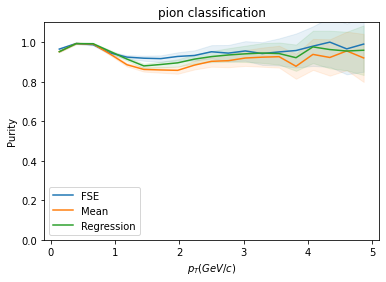

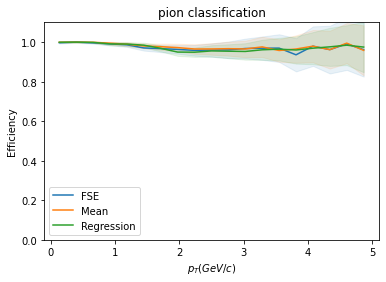

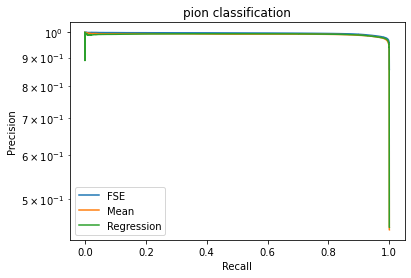

100%|██████████| 12899/12899 [00:14<00:00, 902.86it/s]


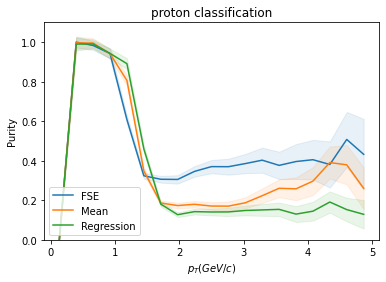

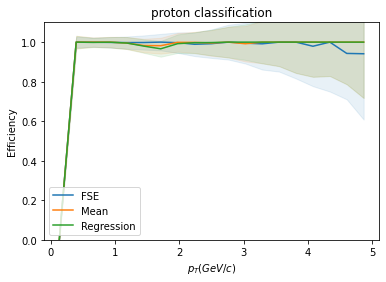

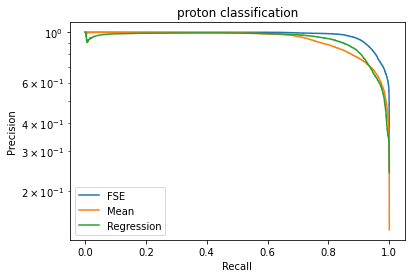

100%|██████████| 12899/12899 [00:16<00:00, 777.95it/s]


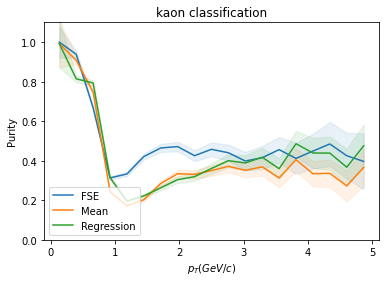

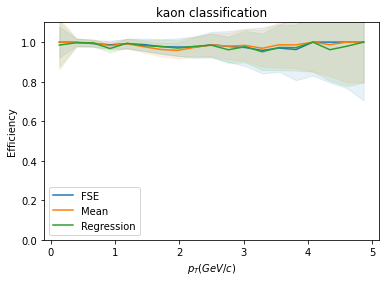

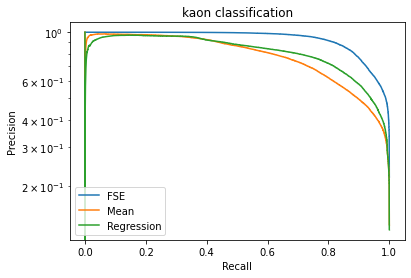

100%|██████████| 12899/12899 [00:14<00:00, 899.57it/s]


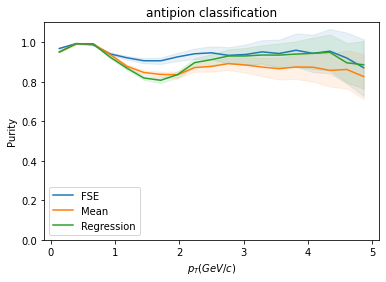

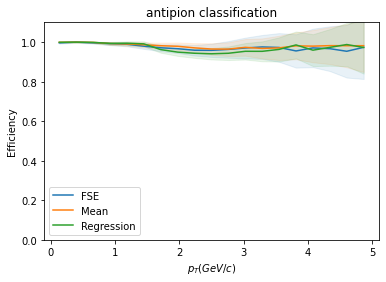

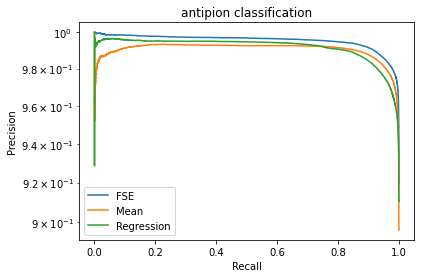

100%|██████████| 12899/12899 [00:12<00:00, 996.08it/s] 


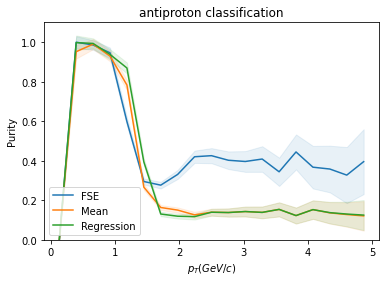

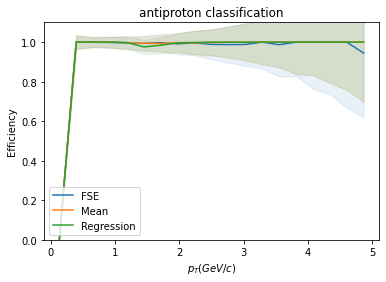

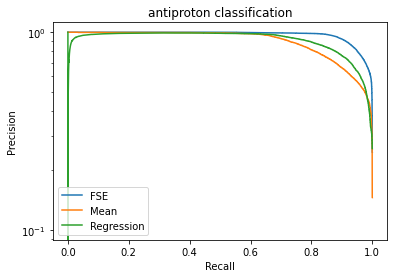

100%|██████████| 12899/12899 [00:12<00:00, 995.14it/s] 


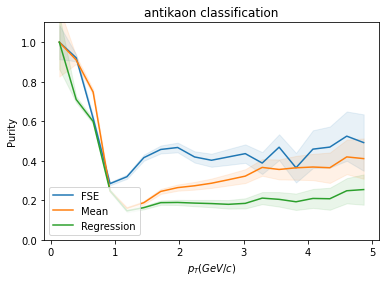

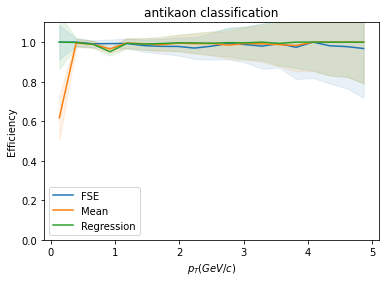

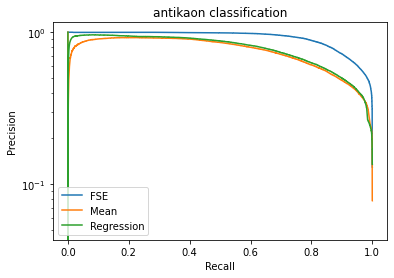

In [4]:
%matplotlib inline

from pdi.constants import PARTICLES_DICT, TARGET_CODES, NUM_WORKERS, P_RANGE, P_RESOLUTION
from pdi.data.types import Split
from pdi.evaluate import get_predictions_and_data

import os
import numpy as np
from pdi.visualise import (
    plot_purity_comparison,
    plot_efficiency_comparison,
    plot_precision_recall_comparison,
)

THRESHOLD = 0.5

data = {}
for target_code in TARGET_CODES:
    for experiment_name, exp_dict in EXPERIMENTS.items():
        data_preparation = exp_dict["data_prep"]
        model = torch.load(f"models/{experiment_name}/{target_code}").to(device)
        model.eval()

        batch_size = 64
        val_loader, test_loader = data_preparation().prepare_dataloaders(batch_size, NUM_WORKERS, [Split.VAL, Split.TEST])


        targets, predictions, add_data = get_predictions_and_data(
            model, test_loader, device
        )

        save_dir = f"reports/figures/{experiment_name}/{target_code}"
        os.makedirs(save_dir, exist_ok=True)

        particle_name = PARTICLES_DICT[target_code]
        selected = predictions > THRESHOLD
        p_min, p_max = P_RANGE
        p_range = np.linspace(p_min, p_max, P_RESOLUTION)
        thresholds = [((p_low, p_high), THRESHOLD) for (p_low, p_high) in zip(p_range[:-1], p_range[1:])]
        # plot_selected_particles(particle_name, selected, fP, fTPCSignal, "fTPCSignal", 15, save_dir)
        # plot_selected_particles(particle_name, selected, fP, fBeta, "fBeta", 1.5, save_dir)
        # plot_contamination(particle_name, targets, selected, fP, 20, p_min, p_max, save_dir)

        data[experiment_name] = {
            "targets": targets == target_code,
            "predictions": predictions,
            "momentum": add_data["fP"], # TODO
            "thresholds": thresholds
        }

    save_dir = f"reports/figures/comparison_with_incomplete/{target_code}"   
    os.makedirs(save_dir, exist_ok=True)
    plot_purity_comparison(particle_name, data, save_dir)
    plot_efficiency_comparison(particle_name, data, save_dir)
    plot_precision_recall_comparison(particle_name, data, save_dir)
